# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.20 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677


When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
import torch
from collections import deque
from config import Config
from networks import Actor, Critic
from memory import ReplayBuffer
from noise import OUNoise
from agent import MultiAgent
from utils import plot_scores
import matplotlib.pyplot as plt
%matplotlib inline

import imp, agent, networks, config, math
imp.reload(agent)
imp.reload(networks)
imp.reload(config)
from agent import MultiAgent
from networks import Actor, Critic
from config import Config

env_info = env.reset(train_mode=True)[brain_name]
config = Config()

config.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config.num_agents = num_agents
config.states = states
config.state_size = state_size
config.action_size = action_size

config.actor_network_fn = lambda: Actor(config.action_size, config.state_size, config.seed, config.actor_hidden_units).to(config.device)
config.actor_optimizer_fn = lambda params: torch.optim.Adam(params, lr=config.actor_learning_rate)

config.critic_network_fn = lambda: Critic(config.action_size, config.state_size, config.seed, config.critic_hidden_units).to(config.device)
config.critic_optimizer_fn = lambda params: torch.optim.Adam(params, lr=config.critic_learning_rate)

config.memory_fn = lambda: ReplayBuffer(config.action_size, config.buffer_size, config.batch_size, config.seed, config.device)
config.noise_fn = lambda: OUNoise(config.action_size, config.seed)


In [7]:
multi_agent = MultiAgent(config)

def ddpg(n_episodes=20000, min_n_episodes=100, max_t=2000, print_every=100, target_mean_scores_deque=6.0, train_mode=True):
    is_solved = False
    best_average_score = -math.inf
    scores_deque = deque(maxlen=print_every)
    scores = []    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations  
        multi_agent.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            actions = multi_agent.act(states)
            env_info = env.step(actions)[brain_name]   

            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            
            if train_mode:              
                for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                    multi_agent.step(state, action, reward, next_state, done, t)
                    
#             multi_agent.step(states, actions, rewards, next_states, dones)
            
            states = next_states
            score += rewards
#             if any(dones):
#                 break 

        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        
        print('\rEpisode {}\tAverage Score: {:.2f} (Previous Best Average Score: {:.2f})'.format(i_episode, np.mean(scores_deque), best_average_score), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} (Previous Best Average Score: {:.2f})'.format(i_episode, np.mean(scores_deque), best_average_score))
            plot_scores(scores)
                          
        if np.mean(scores_deque) >= target_mean_scores_deque:
            # print only once when the environment is first resolved 
            if not is_solved:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
                is_solved = True
                if i_episode <= min_n_episodes:
                    print('\nKeep training until i_episode is over min_n_episodes {:d} (current i_episode = {:d})'.format(min_n_episodes, i_episode))
                else:
                    print('\nStop training since i_episode is over min_n_episodes {:d} & Average Score >= target_mean_scores_deque = {:.2f} (current i_episode = {:d})'.format(min_n_episodes, target_mean_scores_deque, i_episode))
                
            # Save when best_average_score is renewed as well as np.mean(scores_deque) >= target_mean_scores_deque
            if train_mode and (np.mean(scores_deque) > best_average_score):
                print('\nCheckpoint files being saved...')
                for i, ddpg_agent in enumerate(multi_agent.ddpg_agents):
                    print('\nSaving checkpoint_actor_' + str(i) + '.pth')
                    torch.save(ddpg_agent.actor_local.state_dict(), 'checkpoint_actor_' + str(i) + '.pth')
                    print('\nSaving checkpoint_critic_' + str(i) + '.pth')
                    torch.save(ddpg_agent.critic_local.state_dict(), 'checkpoint_critic_' + str(i) + '.pth')
               
            # Keep or stop training
            if is_solved and i_episode > min_n_episodes:
                break
        
        if np.mean(scores_deque) > best_average_score:
            print('\nBest Average Score now updated from {:.2f} to {:.2f}'.format(best_average_score, np.mean(scores_deque)))
            best_average_score = np.mean(scores_deque)
            
    return scores

Episode 100	Average Score: 4.55
Episode 200	Average Score: 5.14
Episode 240	Average Score: 5.15

KeyboardInterrupt: 

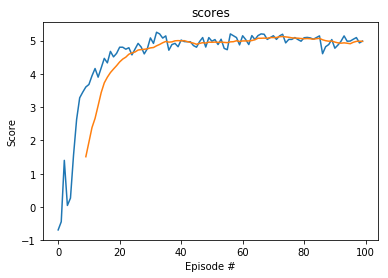

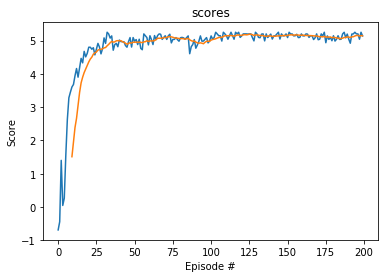

In [13]:
scores = ddpg(min_n_episodes=100, target_mean_scores_deque=6.0)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

plot_scores(scores)

In [9]:
# For reply to the reviewer's comments
# Cell for calculation to find out at which i_episode provides the first score greater than 0.5
multi_agent = MultiAgent(config, load_from_files=False)
score = ddpg(min_n_episodes=100, target_mean_scores_deque=0.5, train_mode=True)

Episode 1	Average Score: -0.69 (Previous Best Average Score: -inf)
Best Average Score now updated from -inf to -0.69
Episode 3	Average Score: -0.67 (Previous Best Average Score: -0.69)
Best Average Score now updated from -0.69 to -0.67
Episode 4	Average Score: -0.66 (Previous Best Average Score: -0.67)
Best Average Score now updated from -0.67 to -0.66
Episode 5	Average Score: -0.46 (Previous Best Average Score: -0.66)
Best Average Score now updated from -0.66 to -0.46
Episode 6	Average Score: -0.30 (Previous Best Average Score: -0.46)
Best Average Score now updated from -0.46 to -0.30
Episode 7	Average Score: -0.02 (Previous Best Average Score: -0.30)
Best Average Score now updated from -0.30 to -0.02
Episode 8	Average Score: 0.20 (Previous Best Average Score: -0.02)
Best Average Score now updated from -0.02 to 0.20
Episode 9	Average Score: 0.34 (Previous Best Average Score: 0.20)
Best Average Score now updated from 0.20 to 0.34
Episode 10	Average Score: 0.61 (Previous Best Average Sc

KeyboardInterrupt: 

In [ ]:
# env.close()

In [15]:
!jupyter nbconvert "Tennis.ipynb"
!!apt-get -y update && apt-get install -y zip
!zip project3.zip ./*

[NbConvertApp] Converting notebook Tennis.ipynb to html
/opt/conda/lib/python3.6/site-packages/nbconvert/filters/highlight.py:138: UserWarning: IPython3 lexer unavailable, falling back on Python 3
  warn("IPython3 lexer unavailable, falling back on Python 3")
[NbConvertApp] Writing 367198 bytes to Tennis.html
  adding: README.md (deflated 67%)
  adding: Report.md (deflated 41%)
  adding: Report.pdf (deflated 4%)
  adding: Tennis.html (deflated 77%)
  adding: Tennis.ipynb (deflated 47%)
  adding: __pycache__/ (stored 0%)
  adding: agent.py (deflated 74%)
  adding: checkpoint_actor_0.pth (deflated 8%)
  adding: checkpoint_actor_1.pth (deflated 8%)
  adding: checkpoint_critic_0.pth (deflated 7%)
  adding: checkpoint_critic_1.pth (deflated 7%)
  adding: config.py (deflated 71%)
  adding: jupyter.png (deflated 1%)
  adding: memory.py (deflated 68%)
  adding: networks.py (deflated 76%)
  adding: noise.py (deflated 54%)
  adding: python/ (stored 0%)
  adding: soccer.gif (deflated 9%)
  adding